In [97]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from network import solve_ode_network
from scipy.signal import hilbert, butter, filtfilt

In [98]:
def plot_x_values(x_values):
    j = np.array([0, 20, 40])
    fig, axes = plt.subplots(len(j), 1, figsize=(18, len(j)*3))

    for i in range(len(j)):
        axes[i].plot(x_values[:,j[i]], label=f'j={j[i]}')
        axes[i].set_xlabel('Time Steps')
        axes[i].set_ylabel(f'x_{j[i]}')
        axes[i].set_title(f'Solution of ODE for x_{j[i]}')
        axes[i].legend()

    plt.tight_layout()


In [99]:
mat = loadmat('../references/AAL78/C78.mat')
C = mat['C']

In [115]:
num_steps = 1000  # total steps
dt = 0.01  # time step
a = 0.0  # intrinsic dynamics parameters for each neuron
omega = 2 * np.pi * 12  # angular frequencies for each neuron
beta = 55  # noise level

# Solve the ODEs
x_values, y_values = solve_ode_network(num_steps, dt, a, omega, beta, C)

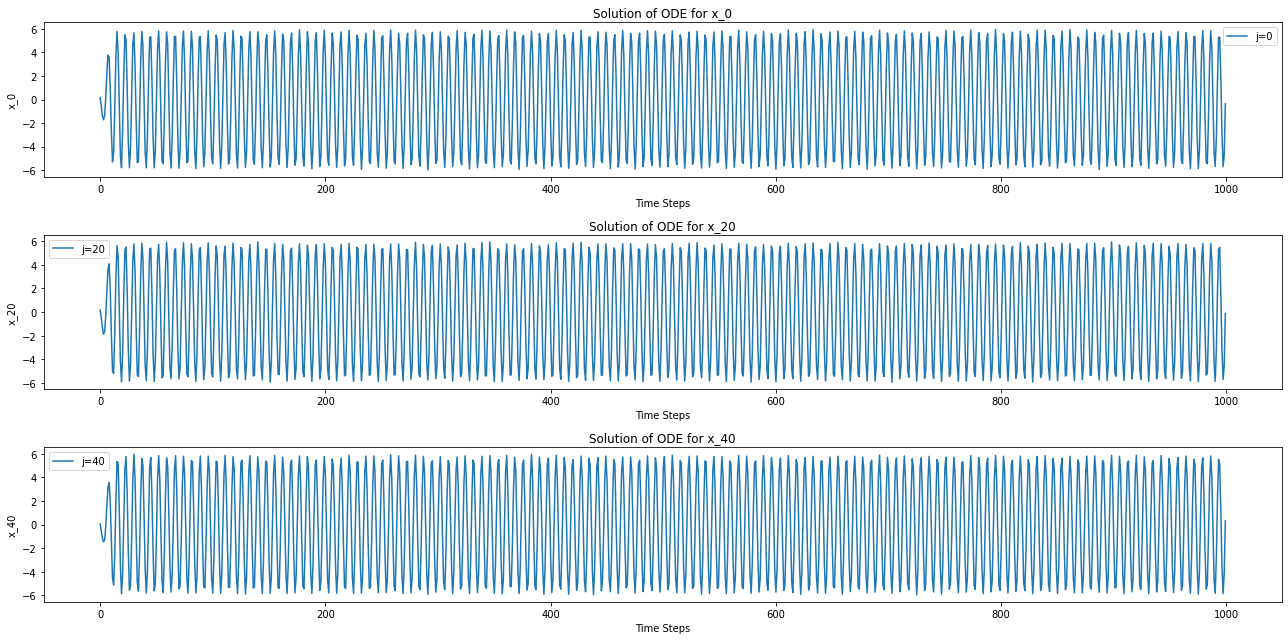

In [116]:
plot_x_values(x_values)

In [117]:
# Function to apply band-pass filter
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Function to apply low-pass filter
def lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y


In [118]:
# Filter parameters
f = 12
fs = 1/dt
band_lowcut = f - 2
band_highcut = f + 2
lowpass_cutoff = 0.2

In [119]:
# Preallocate arrays for filtered signals
filtered_x = np.zeros_like(x_values)
filtered_y = np.zeros_like(y_values)

In [120]:
# Band-pass filter for each region
for i in range(78):
    filtered_x[:, i] = bandpass_filter(x_values[:, i], band_lowcut, band_highcut, fs)
    filtered_y[:, i] = bandpass_filter(y_values[:, i], band_lowcut, band_highcut, fs)

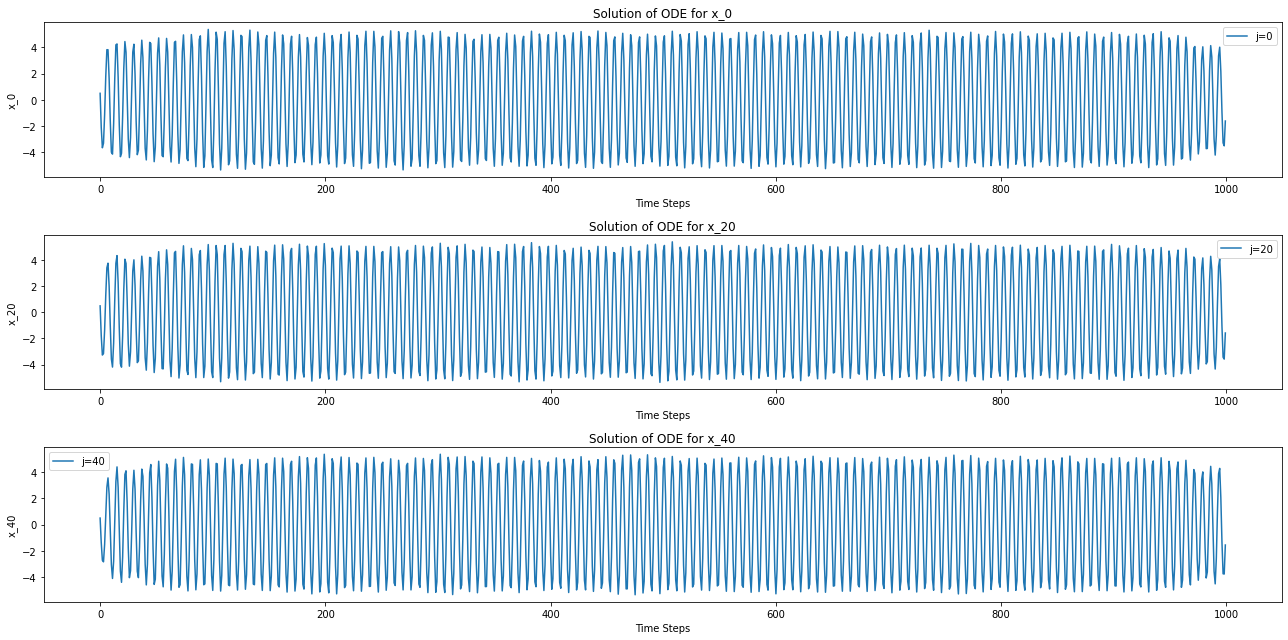

In [121]:
plot_x_values(filtered_x)

In [122]:
# Calculate the Hilbert transform to get the instantaneous amplitude
amplitude_env_x = np.abs(hilbert(filtered_x))
amplitude_env_y = np.abs(hilbert(filtered_y))

In [123]:
# Low-pass filter the amplitude envelope
ultra_slow_x = np.zeros_like(amplitude_env_x)
ultra_slow_y = np.zeros_like(amplitude_env_y)

In [124]:
for i in range(78):
    ultra_slow_x[:, i] = lowpass_filter(amplitude_env_x[:, i], lowpass_cutoff, fs)
    ultra_slow_y[:, i] = lowpass_filter(amplitude_env_y[:, i], lowpass_cutoff, fs)

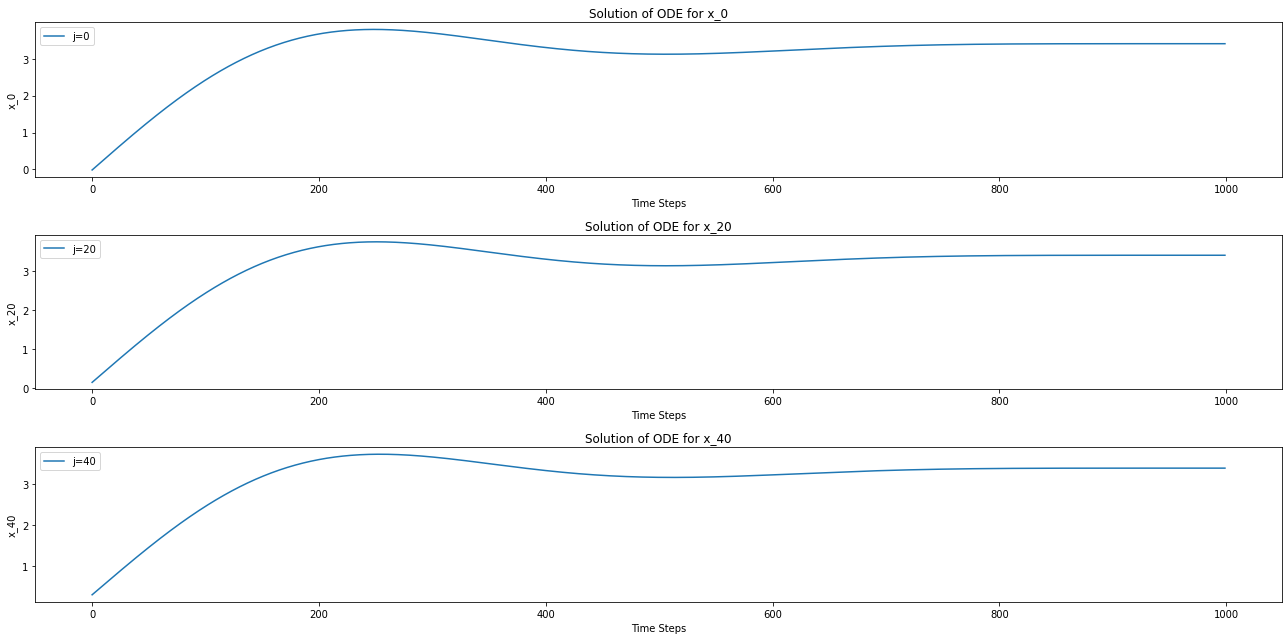

In [125]:
plot_x_values(ultra_slow_x)